In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import mlflow
import dagshub
from dagshub import dagshub_logger

2025-05-13 22:33:39.271118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 22:33:39.291710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747168419.314958   26398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747168419.321903   26398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747168419.338202   26398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# MLflow - Dagshub initialization
mlflow.set_tracking_uri("https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow")

dagshub.init(repo_owner='alfoCaiazza', repo_name='FingerSpellIT', mlflow=True)
dagshub_log = dagshub_logger(metrics_path="metrics", hparams_path="params")

Accessing as alfoCaiazza

Repository FingerSpellIT doesn't exist, creating it under current user.

Initialized MLflow to track repo "alfoCaiazza/FingerSpellIT"

Repository alfoCaiazza/FingerSpellIT initialized!

In [3]:
# To avoid OOM errors, setting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(f"GPU: {gpu}")
    tf.config.experimental.set_memory_growth(gpu, True) # Keeping the use of memory limited to prevent errors

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
train_dir = '../data/processed/train'
val_dir = '../data/processed/val'
test_dir = '../data/processed/test'

# Automatically creates a dataset form the referred directory. Load the full dataset, shuffle = True ensures randomness
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=123
)

class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=123
)

Found 4489 files belonging to 22 classes.


I0000 00:00:1747168430.289294   26398 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 962 files belonging to 22 classes.
Found 977 files belonging to 22 classes.


In [5]:
# Pre-processing sequential model
preprocessing_model = tf.keras.Sequential([
    # Normalizing the images for ResNet50 model (0,1)
    tf.keras.layers.Rescaling(1./255), 

    # # Data augmentation:
    # tf.keras.layers.RandomFlip("horizontal"),  # Simulating left hand
    # tf.keras.layers.RandomRotation(0.1),       # Rotations, max ±10%

    # # Gaussiano noise
    # tf.keras.layers.Lambda(
    #     lambda x: tf.clip_by_value(
    #         x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.05), 0.0, 1.0
    #     )
    # ),

    # tf.keras.layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (preprocessing_model(x), y))
val_ds = val_ds.map(lambda x, y: (preprocessing_model(x), y))
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

In [6]:
# Importing net for transfer learning
base_model = ResNet50(
    weights='imagenet',
    include_top=False, # Excludes the first layer
    input_shape=(224,224, 3) # Specifing input shape
)

# Freezing net layers
base_model.trainable = False

# Adding more layer to the net from its output and adapting it to a multi-class classification task 
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x) 

# Creiamo il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Compiliamo il modello
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

In [8]:
# Logging parameters with MLflow
batch_size = 128
epochs = 10

In [9]:
with mlflow.start_run(run_name="Model parameters"):

    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    history = model.fit(
        train_ds,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    # Logging metrics for each epochs
    for i in range(epochs):
        mlflow.log_metric("train_loss", history.history['loss'][i], step=i)
        mlflow.log_metric("val_loss", history.history['val_loss'][i], step=i)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][i], step=i)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][i], step=i)

    # Salving the model
    model.save("../model/model_fingerspelling.h5")
    mlflow.log_artifact("../model/model_fingerspelling.h5")


Epoch 1/10


I0000 00:00:1747168444.103377   26669 service.cc:152] XLA service 0x7f2010001b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747168444.103589   26669 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-05-13 22:34:05.195618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747168447.993214   26669 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-13 22:34:10.539672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4977', 76 bytes spill stores, 76 bytes spill loads

2025-05-13 22:34:10.595470: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.0603 - loss: 3.1692

2025-05-13 22:34:36.470716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4977', 12 bytes spill stores, 12 bytes spill loads

2025-05-13 22:34:37.020291: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4977', 112 bytes spill stores, 112 bytes spill loads

2025-05-13 22:34:37.526074: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4977', 8 bytes spill stores, 8 bytes spill loads

2025-05-13 22:34:37.711247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4977', 1016 bytes spill stores, 1016 bytes spill loads

2025-05-13 22:34:37.844212: I extern

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.0606 - loss: 3.1672

2025-05-13 22:34:51.662198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 588 bytes spill stores, 588 bytes spill loads

2025-05-13 22:34:51.748048: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 476 bytes spill stores, 476 bytes spill loads

2025-05-13 22:34:51.961194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 116 bytes spill stores, 116 bytes spill loads

2025-05-13 22:34:52.026022: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 4 bytes spill stores, 4 bytes spill loads

2025-05-13 22:34:52.132552: I extern

36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 971ms/step - accuracy: 0.0610 - loss: 3.1652 - val_accuracy: 0.0665 - val_loss: 2.9812 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.0889 - loss: 2.9771 - val_accuracy: 0.1299 - val_loss: 2.8291 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.1676 - loss: 2.7992 - val_accuracy: 0.1674 - val_loss: 2.6882 - learning_rate: 0.0010
Epoch 4/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.1962 - loss: 2.6532

2025-05-13 22:35:33.113259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.1973 - loss: 2.6515 - val_accuracy: 0.2453 - val_loss: 2.5538 - learning_rate: 0.0010
Epoch 5/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.2392 - loss: 2.5179

2025-05-13 22:35:45.551849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.2420 - loss: 2.5152 - val_accuracy: 0.2859 - val_loss: 2.4291 - learning_rate: 0.0010
Epoch 6/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.2827 - loss: 2.3925

2025-05-13 22:35:57.083042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.2836 - loss: 2.3910 - val_accuracy: 0.3347 - val_loss: 2.2995 - learning_rate: 0.0010
Epoch 7/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.3424 - loss: 2.2646

2025-05-13 22:36:09.618848: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - accuracy: 0.3429 - loss: 2.2631 - val_accuracy: 0.3482 - val_loss: 2.1988 - learning_rate: 0.0010
Epoch 8/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.3503 - loss: 2.1774

2025-05-13 22:36:22.290856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3523 - loss: 2.1754 - val_accuracy: 0.3805 - val_loss: 2.1262 - learning_rate: 0.0010
Epoch 9/10


2025-05-13 22:36:24.909508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.3766 - loss: 2.0712

2025-05-13 22:36:34.245378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.3777 - loss: 2.0700 - val_accuracy: 0.4200 - val_loss: 2.0151 - learning_rate: 0.0010
Epoch 10/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4318 - loss: 1.9705

2025-05-13 22:36:47.619645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.4322 - loss: 1.9697 - val_accuracy: 0.3919 - val_loss: 1.9648 - learning_rate: 0.0010


🏃 View run Model parameters at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0/runs/cfc62c6c2d0149fa83537ff65159f71e
🧪 View experiment at: https://dagshub.com/alfoCaiazza/FingerSpellIT.mlflow/#/experiments/0


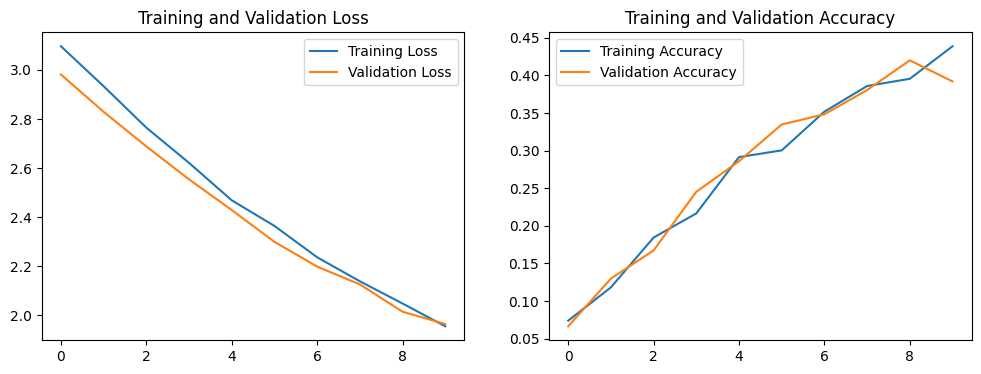

In [10]:
# Plotting loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Evaluation accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=1)

2025-05-13 22:38:07.111923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4099 - loss: 1.9567

2025-05-13 22:38:12.103306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 64 bytes spill stores, 64 bytes spill loads

2025-05-13 22:38:12.788544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 4 bytes spill stores, 4 bytes spill loads

2025-05-13 22:38:13.206378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 588 bytes spill stores, 588 bytes spill loads

2025-05-13 22:38:13.267564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 844 bytes spill stores, 844 bytes spill loads

2025-05-13 22:38:13.341788: I external

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4095 - loss: 1.9534 
Evaluation accuracy: 0.4084


2025-05-13 22:38:22.833727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-13 22:38:23.313996: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-13 22:38:23.366632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 598ms/step


In [12]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           a       0.00      0.00      0.00        37
           b       0.03      0.05      0.04        39
           c       0.07      0.21      0.10        39
           d       0.00      0.00      0.00        41
           e       0.10      0.13      0.11        45
           f       0.00      0.00      0.00        43
           h       0.04      0.04      0.04        45
           i       0.08      0.04      0.06        47
           k       0.03      0.02      0.02        47
           l       0.04      0.04      0.04        47
           m       0.00      0.00      0.00        50
           n       0.03      0.05      0.04        42
           o       0.04      0.02      0.03        41
           p       0.06      0.05      0.05        43
           q       0.05      0.13      0.07        47
           r       0.00      0.00      0.00        46
           t       0.00      0.00      0.00        44
           u       0.04    

/home/acaia/LIS/LIS-Gesture-Translator/.lis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/acaia/LIS/LIS-Gesture-Translator/.lis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/acaia/LIS/LIS-Gesture-Translator/.lis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

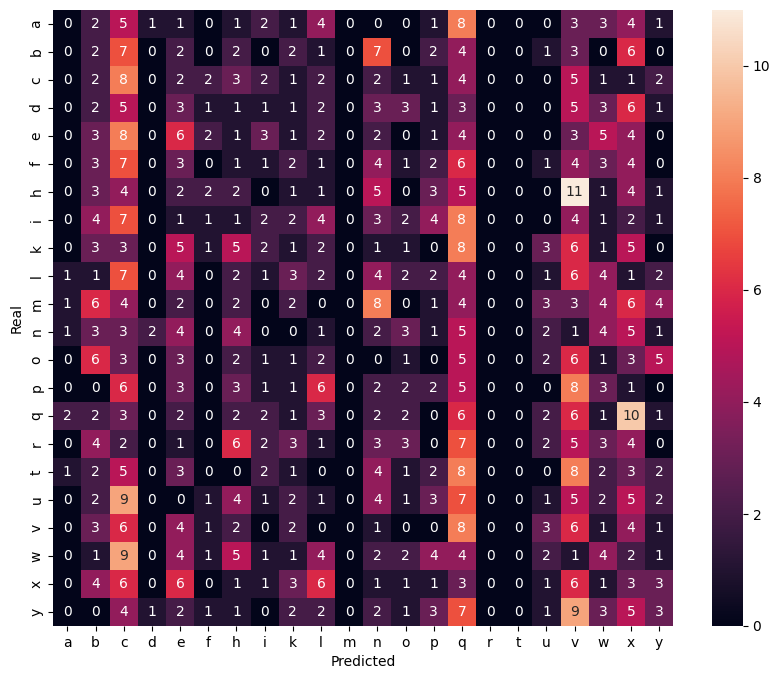

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

In [14]:
mlflow.end_run()